<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/TSLA_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Decision Theory**
##**Project 1: TSLA stock closing price prediction**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

The data that we will be using contain the TSLA stock closing prices from 2010-06-29 until 2024-10-31. The training test will contain data from 2010-06-29 until 2023-12-31 and the validation test after the training process will contain data from 2024-01-01 until 2024-10-31. So all the predictions will be made on new data that will start from date 2024-11-01.

Data saved to close_prices.csv


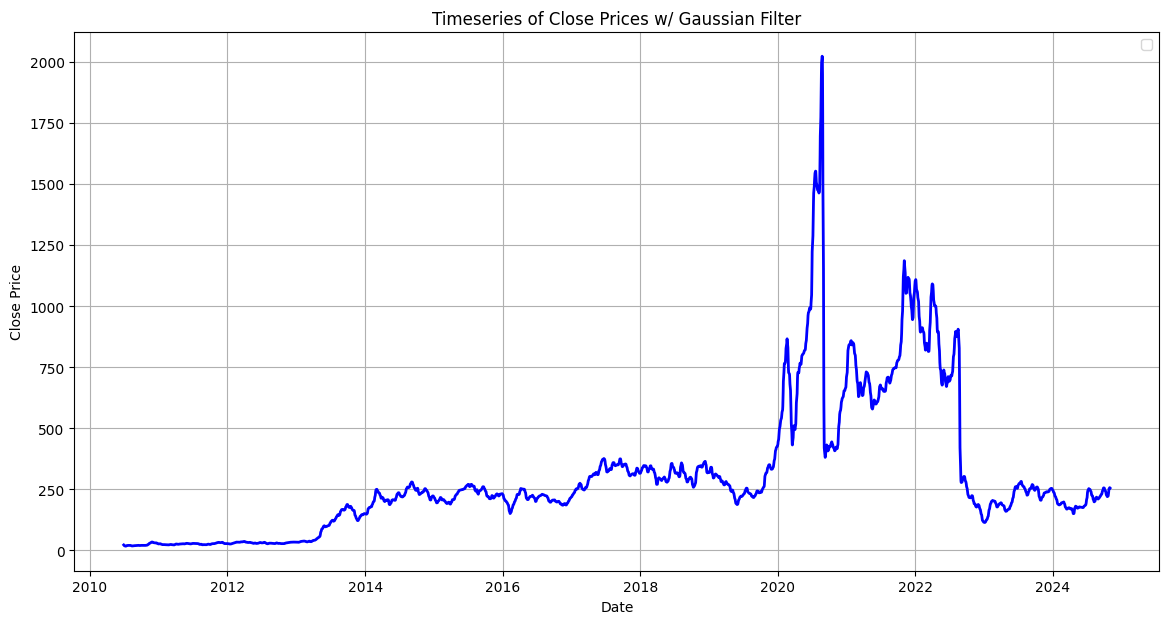

In [7]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

# Apply Gaussian Filter in 'Close' prices for smoothing
sigma = 2
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title('Timeseries of Close Prices w/ Gaussian Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### **Observation**
TSLA stock closing prices exhibit a strong upward trend starting around 2019, which peaks in late 2021 before experiencing a significant drop in 2022. There are periods of high volatility, particularly during the 2020-2022 period, with sharp spikes and drops. This suggests that the stock had frequent fluctuations. After the significant drop in 2022, the closing prices seem to have stabilized, hovering around a lower price range in 2023-2024. Overall, this indicates that the target variable (closing stock price) has a strong dependency on recent, short-term changes rather than on smoothed, long-term trends. In essence, TSLA's price dynamics are better captured by a model that considers recent day-to-day variations, as these fluctuations hold more predictive value than a smoothed view of weekly trends, which would obscure the nuanced daily changes. **Therefore, we will choose to use the daily closing prices as features for the training of the model rather than the weekly averages.** However, we will examine both cases of lagged features in order to showcase the difference in the validation after the training.

Particularly for year 2024 the data appear more stable compared to previous years, with no significant upward or downward trends. **Thus, a Linear Regression could be more adequate for making predictions in data from 2024 of the validation set than a Polynomial Regression.** Higher-degree polynomials are at risk of overfitting, since the model is trained on the 2010-2023 data, which have more spikes and dips than the 2024 data.

**Finally, Linear Regression might generalize better since it won't overfit to the past spikes and dips and it could capture a smooth trend if the testing data behave similarly to validation data.** On the other hand, Polynomial Regression would be less adaptable if testing data turn out to be more stable just like validaton data.






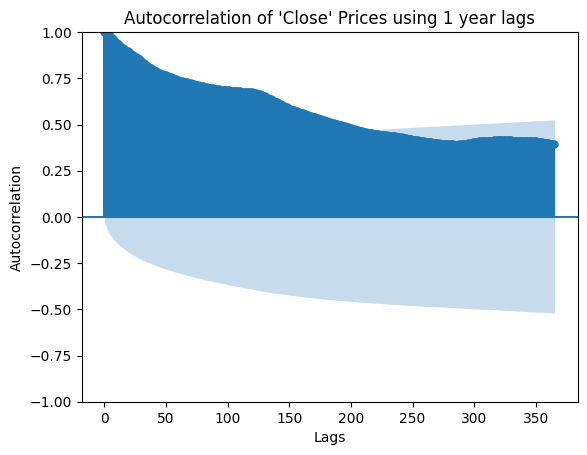

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

# Create ACF plot to find correlation between closing prices for interval of 1 year
plot_acf(df['Close'], lags=365)
plt.title("Autocorrelation of 'Close' Prices using 1 year lags")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

### **Observation**
We observe that the lagged features (daily closing prices) have a strong short-term correlation and there is no periodic trends such as weekly seasonability. Therfore, the lagged daily features will retain the fine-grained details that help capture these dependencies more accurately. With high ACF, sudden changes or trends in the daily prices (like upward or downward trends) are likely to carry forward. **Daily lagged values would capture these shifts more directly than weekly values, which tend to smooth over such changes, potentially missing short-term predictive information.**

#**Question A: Training, Validation and Testing of Linear Regression Model**

##**Using daily closing prices as lagged features**


Model Parameters for N=1:
Bias: 0.4456
Weight for close_t-1: 0.9988
Model Equation:
Close_t = 0.4456 + (0.9988) * close_t-1

Model Parameters for N=2:
Bias: 0.6602
Weight for close_t-1: 1.9376
Weight for close_t-2: -0.9398
Model Equation:
Close_t = 0.6602 + (1.9376) * close_t-1 + (-0.9398) * close_t-2

Model Parameters for N=3:
Bias: 0.0850
Weight for close_t-1: 2.7736
Weight for close_t-2: -2.6631
Weight for close_t-3: 0.8893
Model Equation:
Close_t = 0.0850 + (2.7736) * close_t-1 + (-2.6631) * close_t-2 + (0.8893) * close_t-3

Model Parameters for N=4:
Bias: 0.1331
Weight for close_t-1: 3.4860
Weight for close_t-2: -4.7965
Weight for close_t-3: 3.1111
Weight for close_t-4: -0.8010
Model Equation:
Close_t = 0.1331 + (3.4860) * close_t-1 + (-4.7965) * close_t-2 + (3.1111) * close_t-3 + (-0.8010) * close_t-4

Model Parameters for N=5:
Bias: 0.0313
Weight for close_t-1: 4.1241
Weight for close_t-2: -7.2746
Weight for close_t-3: 6.9314
Weight for close_t-4: -3.5774
Weight for close_t-5: 

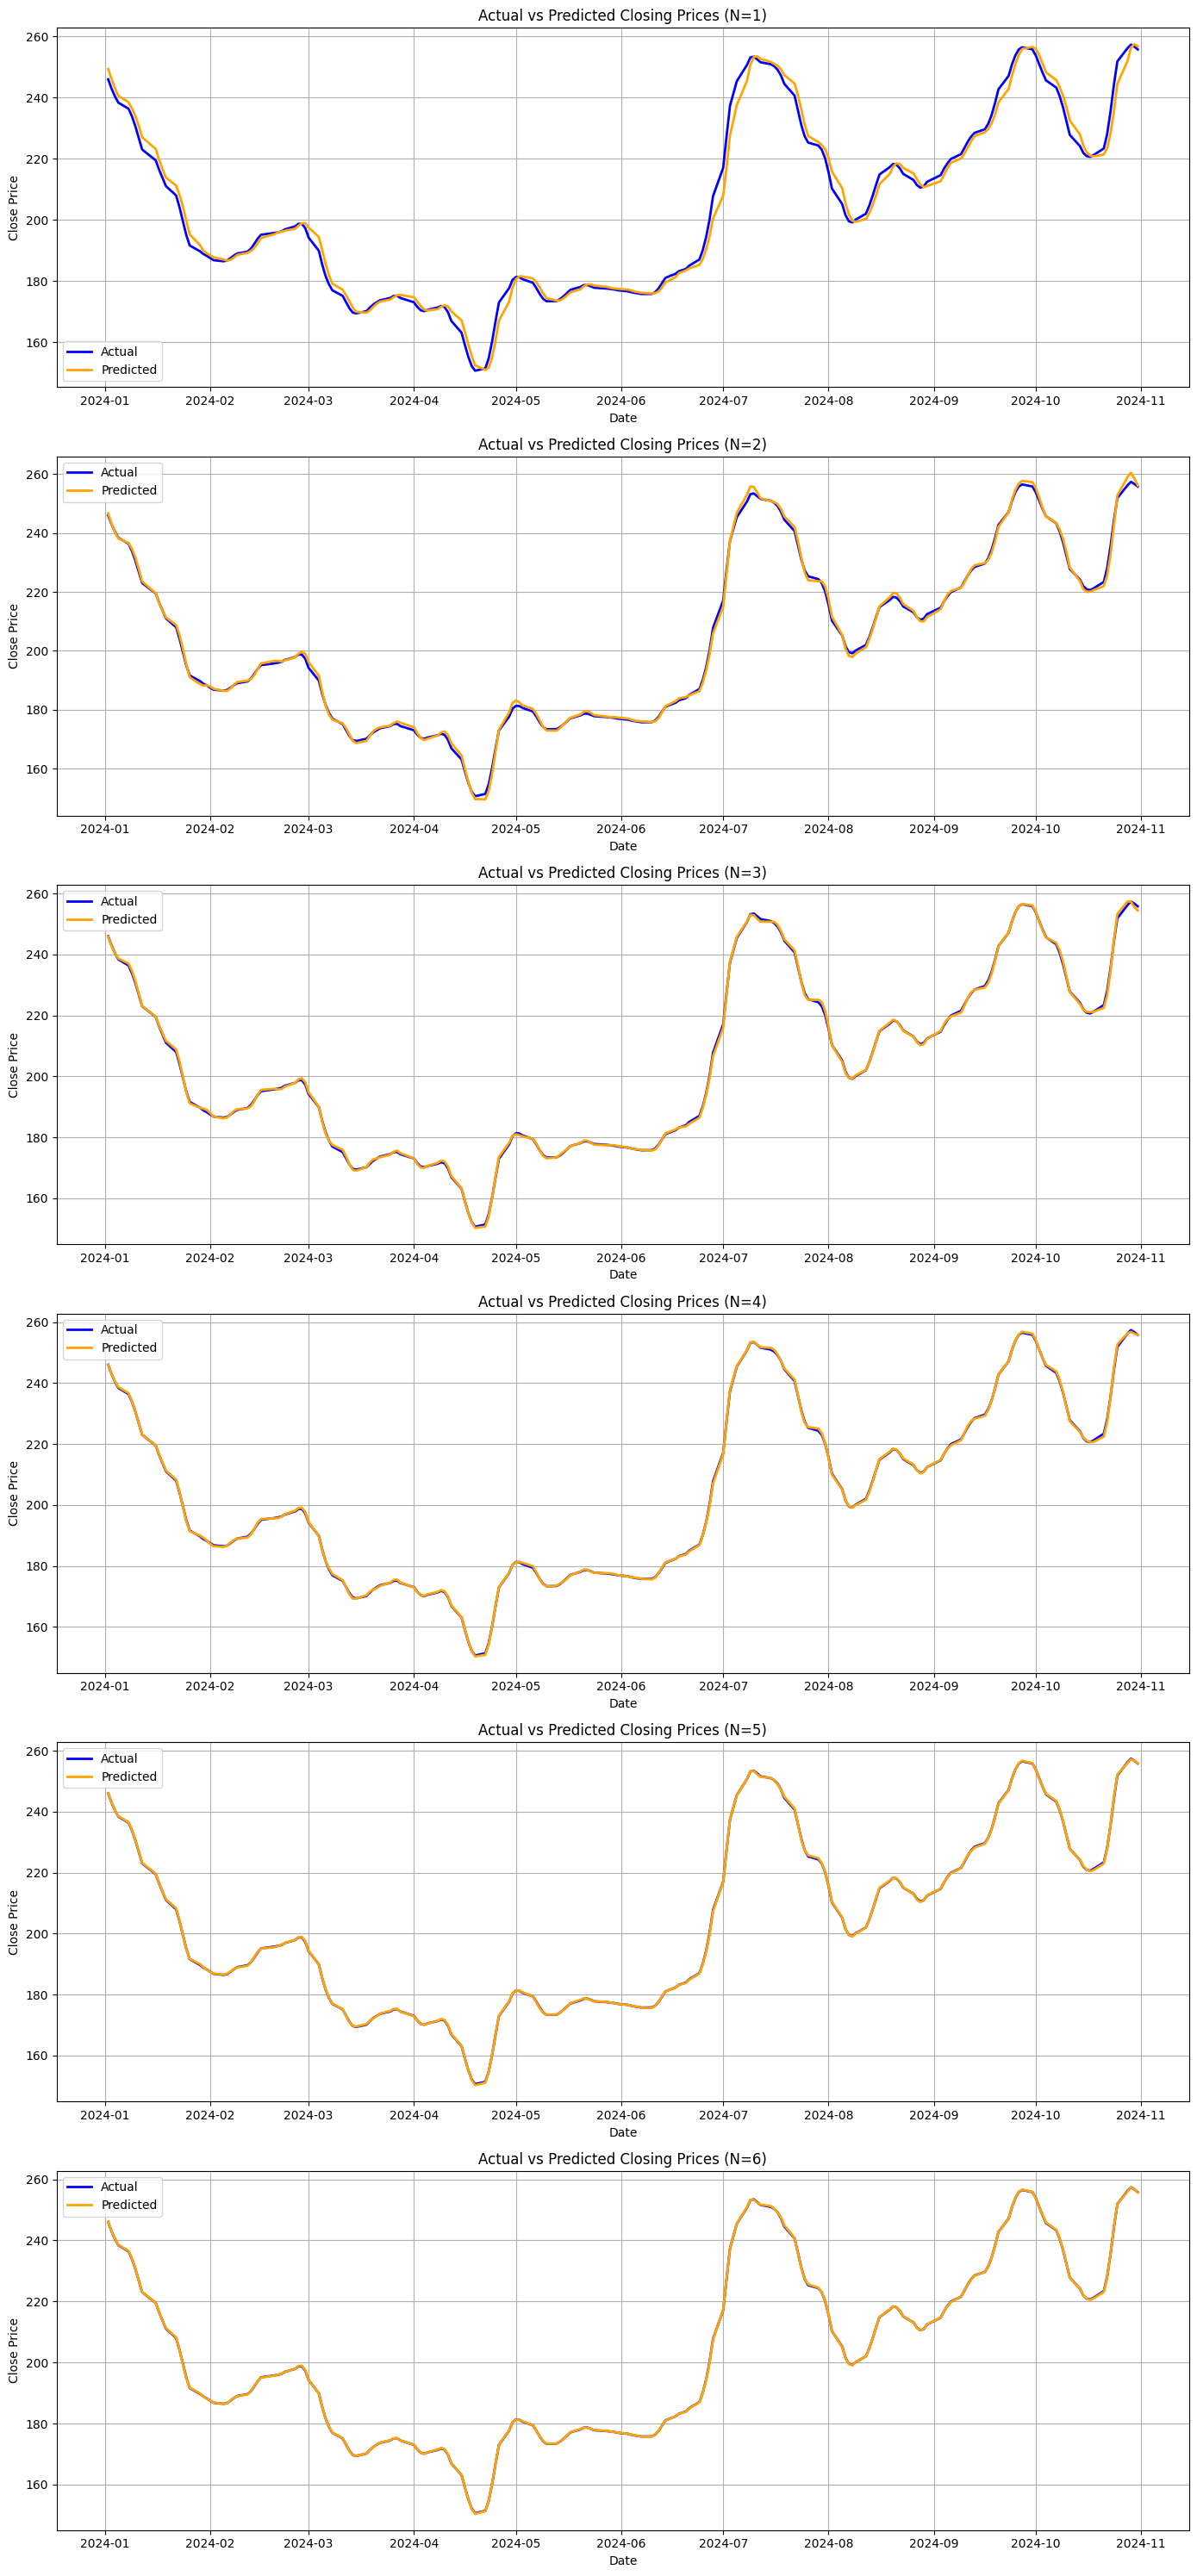

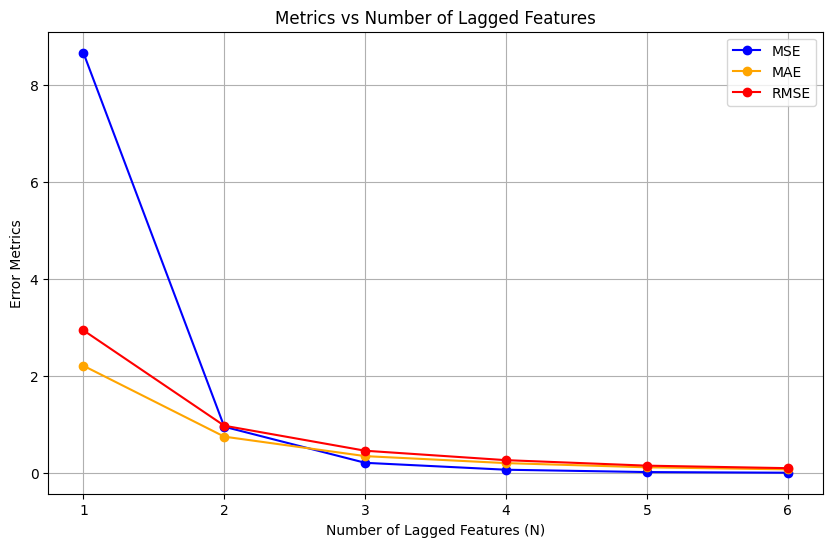

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def linear_regression_model(N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create and fit the Linear Regression model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters (weights and bias)
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Plot the actual and predicted 'close' prices for the different values of lagged features and
# the initial DataFrame
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = linear_regression_model(N, df)  # Call the function here
    results.append((N, mae, rmse, mse))

    axes[idx].plot(dates, y_val, label='Actual', color='blue', linewidth=2)
    axes[idx].plot(dates, y_pred, label='Predicted', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model parameters
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias:.4f}")
    equation = f"Close_t = {bias:.4f}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef:.4f}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef:.4f}")
    print("Model Equation:")
    print(equation)

results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

###**Observation**
We can observe that there is a significant drop in all Error Metrics when moving from N=1 to N=2. This suggests that having at least two lagged features improves the model's predictive power substantially. After N=3 the Error Metrics begin to stabilize, showing minimal improvement as N increases. This indicates that adding more lagged features beyond 3-4 doesn't contribute much additional predictive power.This means that the optimal amount of lagged features is 3-4 and with these the model can be trained really efficiently. The usage of more lagged features (probably 5-6 or even more) could lead to overfitting. **In general, we can see that indeed the Linear Regression Model performs really well on the validation dataset, since the data show a stable and flat trend. Also, we can expect that the Polynomial Regression in Question B will have a poorer performance.**

So, we will use this version of the Linear Regression Model with 4 lagged features in order to predict the TSLA stock closing prices from 2024-11-01 until 2024-11-24.

         Date  Predicted Close
0  2024-11-01       256.172249
1  2024-11-02       258.620195
2  2024-11-03       263.138304
3  2024-11-04       269.045965
4  2024-11-05       275.277800
5  2024-11-06       280.761245
6  2024-11-07       284.745654
7  2024-11-08       286.989563
8  2024-11-09       287.768253
9  2024-11-10       287.723361
10 2024-11-11       287.621313
11 2024-11-12       288.106095
12 2024-11-13       289.522143
13 2024-11-14       291.851741
14 2024-11-15       294.770601
15 2024-11-16       297.788958
16 2024-11-17       300.423931
17 2024-11-18       302.346657
18 2024-11-19       303.462928
19 2024-11-20       303.911754
20 2024-11-21       303.993279
21 2024-11-22       304.057367
22 2024-11-23       304.391942
23 2024-11-24       305.145006


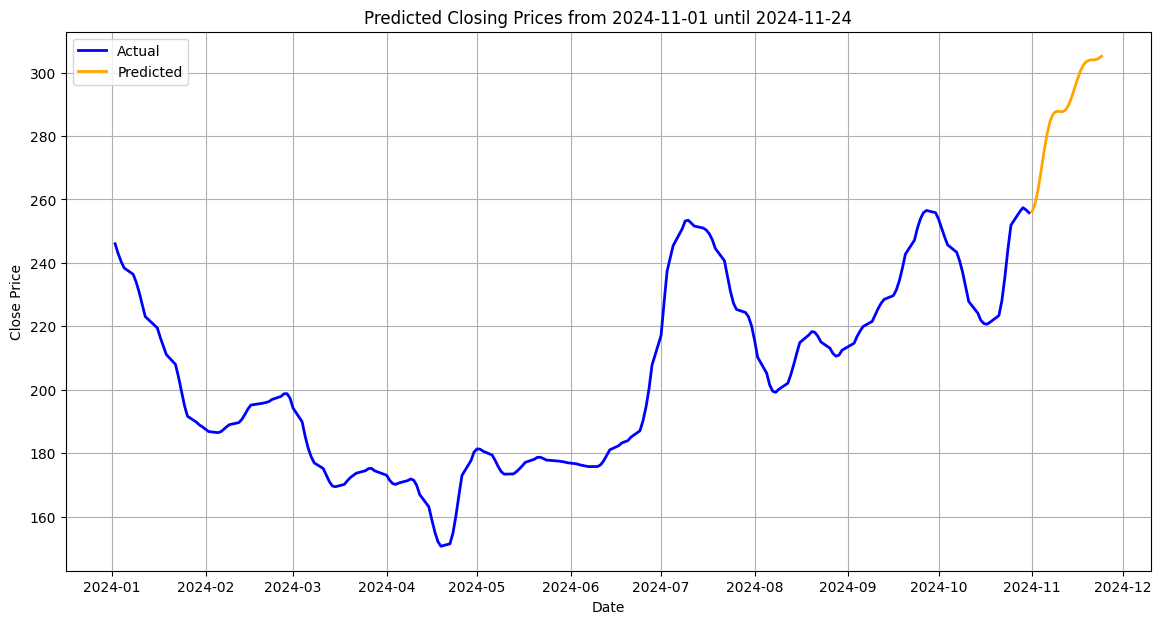

<Figure size 640x480 with 0 Axes>

In [14]:
# Function to predict close prices for new dates
def predict_close_price(df, weights, bias, start_date, num_days):
    predictions = []
    last_known_dates = df['Date'].values # Last known dates
    last_known_prices = df['Close'].values # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices[::-1], weights) + bias # Put the lagged features in the equation of the model and make the prediction
        predictions.append(predicted_close)

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)  # Shift prices

    return predictions

# Train the model with the best value of lagged features, which is N=4
N = 4
_, _, _, _, _, _, weights, bias = linear_regression_model(N, df)

# Make predictions starting from '2024-11-01' until '2024-11-24'
start_date = '2024-11-01'
num_days = 24
predicted_prices = predict_close_price(df, weights, bias, start_date, num_days)

# Create a DataFrame for predicted prices with corresponding dates
predicted_dates = [pd.to_datetime(start_date) + pd.Timedelta(days=i) for i in range(num_days)]
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices})
print(predictions_df)

# Filter to keep only predictions for the year 2024
predictions_df = predictions_df[predictions_df['Date'].dt.year == 2024]

# Combine predictions with the initial DataFrame
df_combined = pd.concat([df, predictions_df], ignore_index=True)

# Plot the actual and predicted 'close' prices for November 2024
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df[df['Date'].dt.year == 2024]['Date'], df[df['Date'].dt.year == 2024]['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted', color='orange', linestyle='-', linewidth=2)
ax.set_title('Predicted Closing Prices from 2024-11-01 until 2024-11-24')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.show()

plt.tight_layout()
plt.show()

###**Real TSLA stock closing prices from November 1st until November 24th**

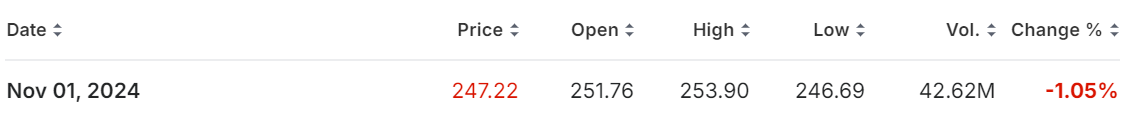

##**Using weekly average closing prices as lagged features**


Model Parameters for N=1:
Bias: 10.7190
Weight for close_t-1: 0.9662
Model Equation:
Close_t = 10.7190 + (0.9662) * close_t-1

Model Parameters for N=2:
Bias: 11.4199
Weight for close_t-1: 1.0293
Weight for close_t-2: -0.0653
Model Equation:
Close_t = 11.4199 + (1.0293) * close_t-1 + (-0.0653) * close_t-2

Model Parameters for N=3:
Bias: 9.6101
Weight for close_t-1: 1.0411
Weight for close_t-2: -0.2523
Weight for close_t-3: 0.1813
Model Equation:
Close_t = 9.6101 + (1.0411) * close_t-1 + (-0.2523) * close_t-2 + (0.1813) * close_t-3

Model Parameters for N=4:
Bias: 9.8103
Weight for close_t-1: 1.0429
Weight for close_t-2: -0.2549
Weight for close_t-3: 0.1921
Weight for close_t-4: -0.0104
Model Equation:
Close_t = 9.8103 + (1.0429) * close_t-1 + (-0.2549) * close_t-2 + (0.1921) * close_t-3 + (-0.0104) * close_t-4

Model Parameters for N=5:
Bias: 9.6662
Weight for close_t-1: 1.0431
Weight for close_t-2: -0.2612
Weight for close_t-3: 0.2005
Weight for close_t-4: -0.0448
Weight for close_t

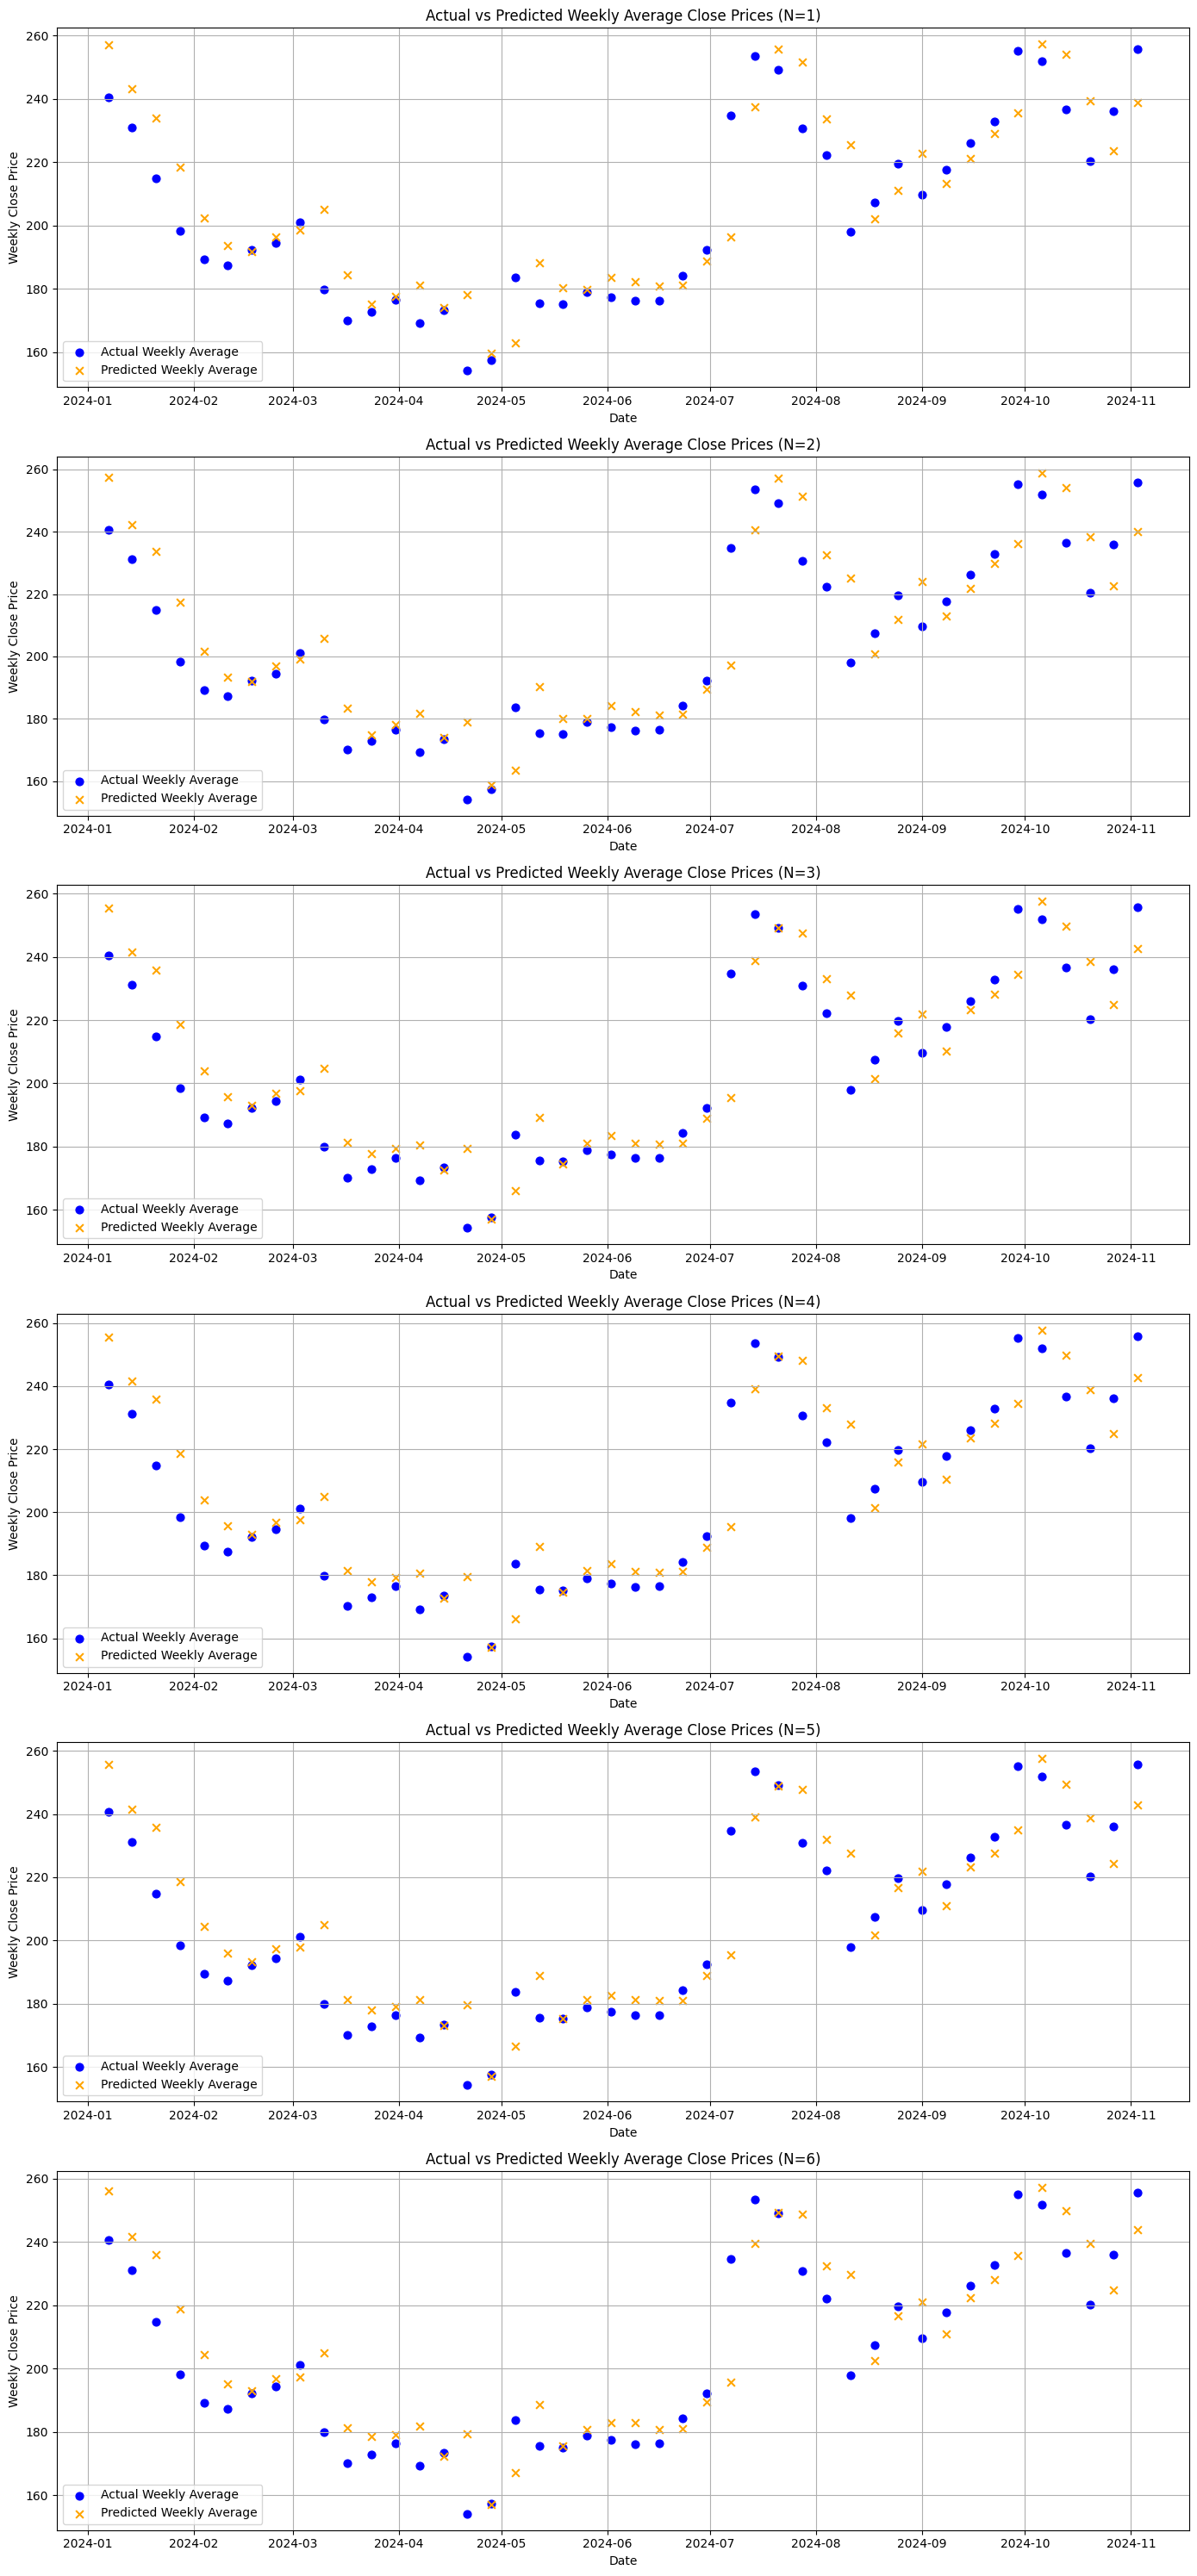

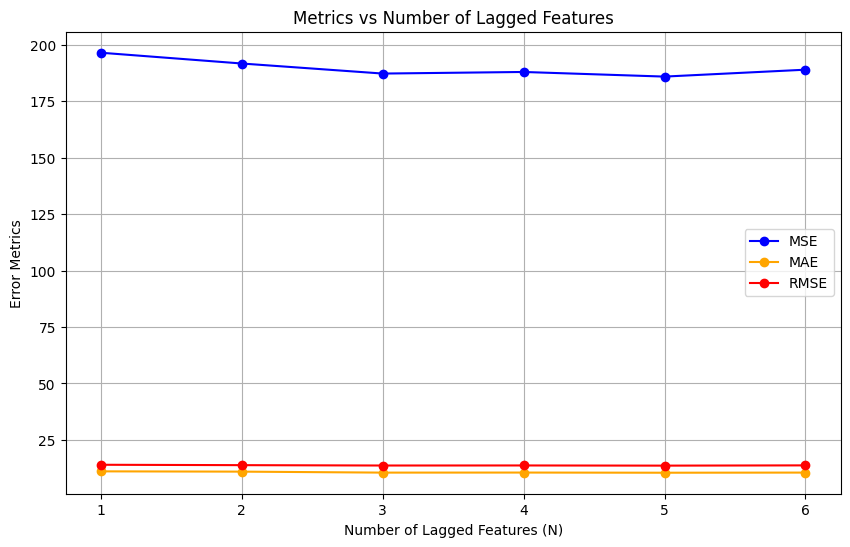

In [15]:
# We delete the predicted data for November 2024 from the initial DataFrame and keep the initial data
del df
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

# Resample the initial data to weekly 'close' price averages
weekly_avg_df = df.set_index('Date').resample('W').mean().reset_index()

# Plot the actual and predicted 'close' prices for the different values of lagged features and
# the new DataFrame
num_tests = 6  # Test lagged features from N=1 to N=6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    # Run model and store results
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = linear_regression_model(N, weekly_avg_df)
    results.append((N, mae, rmse, mse))

    # Plot only one point for each week not a continuous line
    axes[idx].scatter(dates, y_val, label='Actual Weekly Average', color='blue', s=40, marker='o')
    axes[idx].scatter(dates, y_pred, label='Predicted Weekly Average', color='orange', s=40, marker='x')
    axes[idx].set_title(f'Actual vs Predicted Weekly Average Close Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Weekly Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model parameters
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias:.4f}")
    equation = f"Close_t = {bias:.4f}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef:.4f}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef:.4f}")
    print("Model Equation:")
    print(equation)

# Display the metrics for each lagged feature count
results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot error metrics vs the number of lagged features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

###**Observaton**
We see that we get really high MSE for all the values of N. This indicates that simply adding lagged values is not significantly improving the model's predictive power. **This would mean that the past values of weekly average closing prices (lags) do not carry enough information to accurately predict future values on their own, which is true, since we saw earlier that the training data values have non-linear relationships and are extremely sensitive  and volatile.** So, we can expect that the predictions made by the model for the testing data will not be as accurate as when we used daily closing prices as lagged features.

        Date  Predicted Weekly Average Close
0 2024-11-03                      256.395215
1 2024-11-10                      255.311541
2 2024-11-17                      257.606244
3 2024-11-24                      260.201251


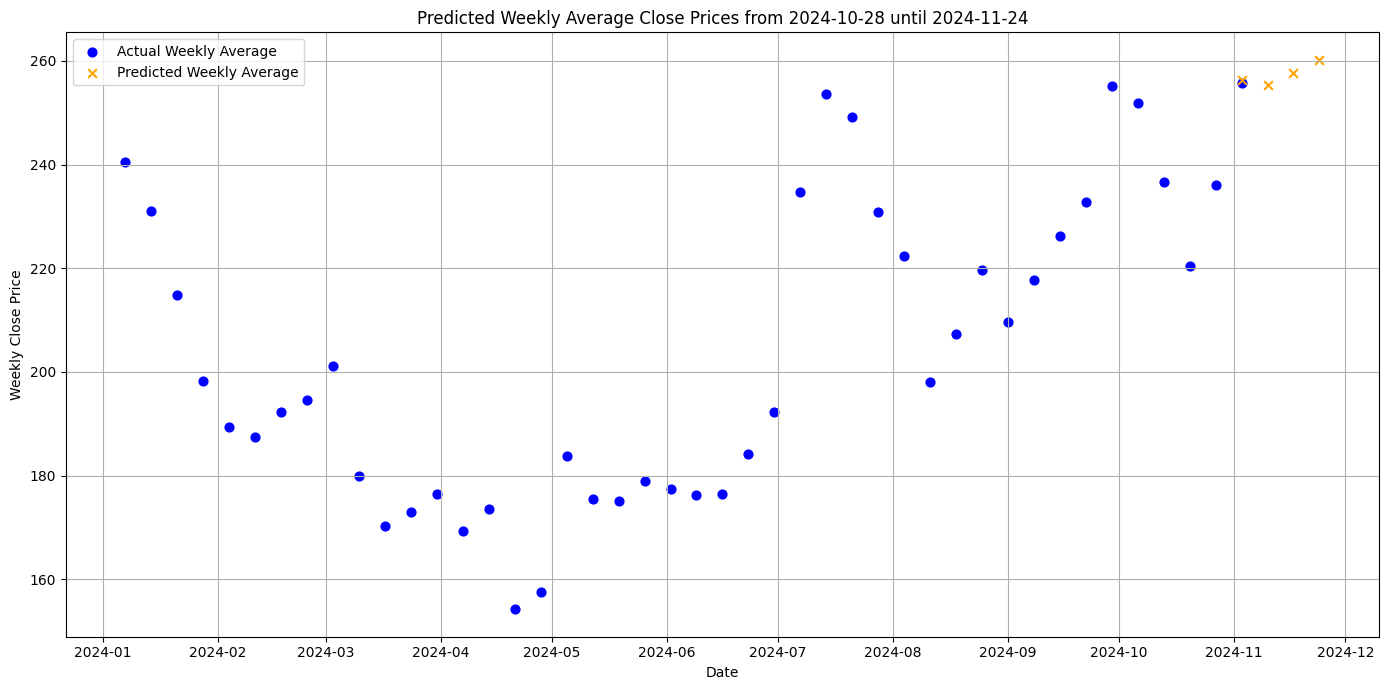

In [16]:
# Train the model with the best value of lagged features, which is N=4
N = 4
_, _, _, _, _, _, weights, bias = linear_regression_model(N, weekly_avg_df)

# Prepare to make predictions for the first 3 weeks of November 2024
last_known_week = weekly_avg_df[weekly_avg_df['Date'] < '2024-11-01'].iloc[-1]
last_n_weeks = [last_known_week['Close']] + list(weekly_avg_df['Close'].iloc[-N+1:].values)

# Predict the weekly averages for 4 weeks of November 2024 from 2024-10-28 until 2024-11-24
predicted_weekly_avg = []
for week in range(4):
    # Calculate the predicted close price for the next week
    predicted_close = np.dot(last_n_weeks[::-1], weights) + bias
    predicted_weekly_avg.append(predicted_close)

    # Update the last N weeks for the next prediction
    last_n_weeks = last_n_weeks[1:] + [predicted_close]

# Create DataFrame for predicted dates and prices
predicted_dates = pd.date_range(start='2024-11-01', periods=4, freq='W')
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Weekly Average Close': predicted_weekly_avg})
print(predictions_df)

# Filter to keep only data from 2024
weekly_avg_df_2024 = weekly_avg_df[weekly_avg_df['Date'].dt.year == 2024]
predictions_df_2024 = predictions_df[predictions_df['Date'].dt.year == 2024]

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(weekly_avg_df_2024['Date'], weekly_avg_df_2024['Close'], color='blue', label='Actual Weekly Average', s=40)
ax.scatter(predictions_df_2024['Date'], predictions_df_2024['Predicted Weekly Average Close'], color='orange', label='Predicted Weekly Average', s=40, marker='x')
ax.set_title('Predicted Weekly Average Close Prices from 2024-10-28 until 2024-11-24')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Close Price')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### **Real TSLA stock weekly average closing prices from October 28th until November 24th**

##**Conclusion**
We conclude that in terms of the **Linear Regression Model** the usage of **4 previous daily closing prices** as features works accurately enough, while the usage of 4 previous weekly average closing prices works not sufficiently, since the data timeseries show non-linearity and instability.

For Question B we will be also using for the same reason the daily closing prices as lagged features.

#**Question B: Training, Validation and Testing of Polynomial Regression Model**

The closing price movements are often non-linear in nature. A linear model assumes a consistent rate of change, which may not capture the complexities of TSLA price dynamics accurately. A polynomial model on the other hand, can capture these non-linear relationships by allowing the model to adjust more flexibly to changes in the trend. So we expect that the Polynomial Regression Model can achieve more accurate predictions if we find a moderate degree.

##**Using L1-Normalization**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+06, tolerance: 2.748e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+06, tolerance: 2.744e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+06, tolerance: 2.741e


Metrics for Different Polynomial Degrees:
    Degree  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0        1             5.529809                 7.981034           63.696898
1        2             6.219767                 8.680299           75.347585
2        3             6.127224                 8.702985           75.741955
3        4             6.478644                 8.855895           78.426878
4        5             6.018912                 8.501164           72.269788
5        6             5.996799                 8.489320           72.068555
6        7             5.858959                 8.369074           70.041405
7        8             5.619362                 8.167397           66.706382
8        9             5.518524                 8.075620           65.215637
9       10             5.473275                 8.022344           64.357999
10      11             5.448108                 7.987725           63.803748
11      12             5.437088  

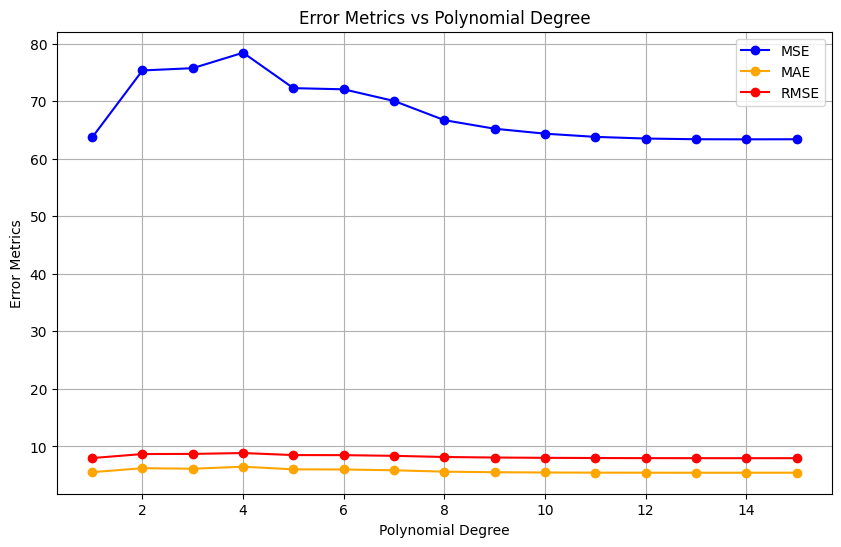


Optimal Polynomial Degree (based on MSE): 14.0


'# Plot the actual and predicted \'close\' prices for different polynomial degrees\nmax_degree = 15  # Testing polynomial degrees from 1 to 15\nN = 4  # We use 4 lagged features\nresults = []\nnum_tests = max_degree\nfig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))\n\nfor degree in range(1, max_degree + 1):\n    mae, rmse, mse, y_val, y_pred, dates, weights, bias = polynomial_regression_model(degree, N, df)  # Call the function here\n    results.append((degree, mae, rmse, mse))\n\n    axes[degree - 1].plot(dates, y_val, label=\'Actual\', color=\'blue\', linewidth=2)\n    axes[degree - 1].plot(dates, y_pred, label=\'Predicted\', color=\'orange\', linewidth=2)\n    axes[degree - 1].set_title(f\'Actual vs Predicted Closing Prices (Degree={degree})\')\n    axes[degree - 1].set_xlabel(\'Date\')\n    axes[degree - 1].set_ylabel(\'Close Price\')\n    axes[degree - 1].legend()\n    axes[degree - 1].grid(True)\n\n    # Print the model parameters\n    print(f"\nModel Parameter

In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# Create a function to train and evaluate polynomial regression with L1-Normalization
# for different polynomial degrees
def polynomial_regression_model(degree, N, data, alpha=1.0):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training and validation sets
    train_data = data[data['Date'] < '2024-01-01']
    validation_data = data[data['Date'] >= '2024-01-01']

    # Prepare features and target for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Create and fit the Lasso regression model with L1 regularization
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)

    # Make predictions using the validation set
    y_pred = model.predict(X_val_poly)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters (weights)
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Testing different polynomial degrees
degrees = range(1, 16)  # Test polynomial degrees from 1 to 15
alpha = 1.0  # Regularization strength for Lasso
results = []

# For N=4 we find the optimal polynomial degree
N = 4  # We use 4 lagged features
for degree in degrees:
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = polynomial_regression_model(degree, N, df, alpha=alpha)
    results.append((degree, mae, rmse, mse))

# Store and print results in a DataFrame
results_df = pd.DataFrame(results, columns=['Degree', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics for Different Polynomial Degrees:')
print(results_df)

# Plot metrics vs polynomial degree
plt.figure(figsize=(10, 6))
plt.plot(results_df['Degree'], results_df['Mean Squared Error'], marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(results_df['Degree'], results_df['Mean Absolute Error'], marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(results_df['Degree'], results_df['Root Mean Squared Error'], marker='o', linestyle='-', color='red', label='RMSE')
plt.title('Error Metrics vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Error Metrics')
plt.legend()
plt.grid(True)
plt.show()

###**Observation**
For lower degrees (from 1 to 4) MSE increases, indicating that very simple polynomial degrees may not capture the data patterns well. After degree 5, MSE begins to gradually decrease, and we observe a stabilization from degree 10 onwards, where MSE reaches lower and more consistent values. Thus, the optimal polynomial degree appears to be around 10. Increasing the degree beyond 10 does not lead to significant improvements in MSE, so a degree of 10 or slightly lower would likely provide a good balance between model complexity and accuracy.

In [ ]:
# Train the model with the best value of lagged features, which is N=4
N = 4
degree = 10
alpha = 1.0
_, _, _, _, _, _, weights, bias = polynomial_regression_model(degree, N, df, alpha)

# Make predictions starting from '2024-11-01' until '2024-11-24'
start_date = '2024-11-01'
num_days = 24
predicted_prices = predict_close_price(df, weights, bias, start_date, num_days)

# Create a DataFrame for predicted prices with corresponding dates
predicted_dates = [pd.to_datetime(start_date) + pd.Timedelta(days=i) for i in range(num_days)]
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices})
print(predictions_df)

# Filter to keep only predictions for the year 2024
predictions_df = predictions_df[predictions_df['Date'].dt.year == 2024]

# Combine predictions with the initial DataFrame
df_combined = pd.concat([df, predictions_df], ignore_index=True)

# Plot the actual and predicted 'close' prices for November 2024
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df[df['Date'].dt.year == 2024]['Date'], df[df['Date'].dt.year == 2024]['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted', color='orange', linestyle='-', linewidth=2)
ax.set_title('Predicted Closing Prices from 2024-11-01 until 2024-11-24')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.show()

plt.tight_layout()
plt.show()

###**Real TSLA stock closing prices from November 1st until November 24th**